In [83]:
# run this to shorten the data import from the files
import os
cwd = os.path.dirname(os.getcwd())+'/'
path_data = os.path.join(os.path.dirname(os.getcwd()), 'datasets/')


In [84]:
import zipfile
import io
import imageio.v2 as imageio

def read_dicom_from_zip(zip_filename, dicom_filename):
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        with zip_ref.open(dicom_filename) as file:
            # Read the DICOM file from the zip as bytes
            dicom_bytes = file.read()
            # Create a BytesIO object from the bytes
            dicom_buffer = io.BytesIO(dicom_bytes)
            # Use imageio to read the DICOM file
            dicom_image = imageio.imread(dicom_buffer)
    return dicom_image

In [85]:
import zipfile
import io
import imageio.v2 as imageio
import numpy as np

def read_dicom_from_zip_folder(zip_filename, folder_name):
    dicom_images = []
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        for file_info in zip_ref.infolist():
            if file_info.filename.startswith(folder_name) and file_info.filename.endswith('.dcm'):
                with zip_ref.open(file_info.filename) as file:
                    # Read the DICOM file from the zip as bytes
                    dicom_bytes = file.read()
                    # Create a BytesIO object from the bytes
                    dicom_buffer = io.BytesIO(dicom_bytes)
                    # Use imageio to read the DICOM file
                    dicom_image = imageio.imread(dicom_buffer)
                    dicom_images.append(dicom_image)
    return np.stack(dicom_images)

In [86]:
im = read_dicom_from_zip(path_data+'sunnybrook-cardiac-mr.zip', 'SCD2001_006/SCD2001_MR_117.dcm')

In [87]:
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt

In [88]:
def format_and_render_plot():
    'Custom function to simplify common formatting operations for exercises.'
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    fig = plt.gcf()
    ax = fig.axes[0]
    ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(ax.get_images()[0], cax=cax)
    plt.sca(ax)
    plt.show()

Num. Labels: 26


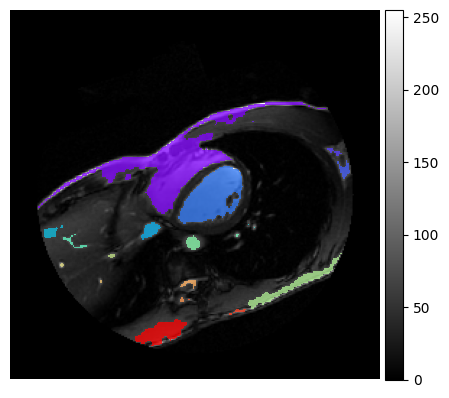

'\nRobust image segmentation is an entire research domain, but the simple principle is to leverage intensity and location information to differentiate objects of interest from the background. Once labeled, the objects can be manipulated easily.\n'

In [89]:
# exercise 01

"""
Segment the heart

In this chapter, we'll work with magnetic resonance (MR) imaging data from the Sunnybrook Cardiac Dataset. The full image is a 3D time series spanning a single heartbeat. These data are used by radiologists to measure the ejection fraction: the proportion of blood ejected from the left ventricle during each stroke.
(https://en.wikipedia.org/wiki/Magnetic_resonance_imaging)
(http://www.cardiacatlas.org/studies/sunnybrook-cardiac-data/)
To begin, segment the left ventricle from a single slice of the volume (im). First, you'll filter and mask the image; then you'll label each object with ndi.label().

This chapter's exercises have the following imports:

import imageio
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt

"""

# Instructions

"""

    Apply a median filter to im. Set the size to 3.
    Create a mask of values greater than 60, then use ndi.binary_closing() to fill small holes in it.
    Extract a labeled array and the number of labels using ndi.label().
---

    Plot the labels array on top of the original image. To create an overlay, use np.where to convert values of 0 to np.nan. Then, plot the overlay with the rainbow colormap and set alpha=0.75 to make it transparent.

"""

# solution

# Smooth intensity values
im_filt = ndi.median_filter(im, size=3)

# Select high-intensity pixels
mask_start = np.where(im_filt > 60, 1, 0)
mask = ndi.binary_closing(mask_start)

# Label the objects in "mask"
labels, nlabels = ndi.label(mask)
print('Num. Labels:', nlabels)

#----------------------------------#

# Create a `labels` overlay
overlay = np.where(labels !=0, labels, np.nan)

# Use imshow to plot the overlay
plt.imshow(im, cmap='gray')
plt.imshow(overlay, cmap='rainbow', alpha=0.75)
format_and_render_plot()

#----------------------------------#

# Conclusion

"""
Robust image segmentation is an entire research domain, but the simple principle is to leverage intensity and location information to differentiate objects of interest from the background. Once labeled, the objects can be manipulated easily.
"""

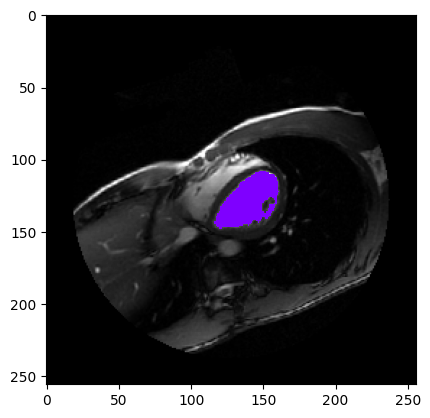

'\nGreat work. When running ndi.label(), the image is traversed from top-left to bottom right, so the generated label value could change depending on how many objects are detected. You may need to plot your labeled image to get the appropriate region.\n\n'

In [90]:
# exercise 02

"""
Select objects

Labels are like object "handles" - they give you a way to pick up whole sets of pixels at a time. To select a particular object:

    Find the label value associated with the object.
    Create a mask of matching pixels.

For this exercise, create a labeled array from the provided mask. Then, find the label value for the centrally-located left ventricle, and create a mask for it.
"""

# Instructions

"""

    Use ndi.label() to assign labels to each separate object in mask.
    Find the index value for the left ventricle label by checking the center pixel (128, 128).
    Create a mask of pixels matching the left ventricle label. Using np.where, set pixels labeled as lv_val to 1 and other values to np.nan.
    Use plt.imshow() to overlay the selected label on the current plot.

"""

# solution

# Label the image "mask"
labels, nlabels = ndi.label(mask)

# Select left ventricle pixels
lv_val = labels[128, 128]
lv_mask = np.where(labels == lv_val, 1, np.nan)

# Overlay selected label
plt.imshow(im, cmap='grey')
plt.imshow(lv_mask, cmap='rainbow')
plt.show()

#----------------------------------#

# Conclusion

"""
Great work. When running ndi.label(), the image is traversed from top-left to bottom right, so the generated label value could change depending on how many objects are detected. You may need to plot your labeled image to get the appropriate region.

"""

Number of objects: 1
Indices for first box: (slice(107, 149, None), slice(116, 162, None))


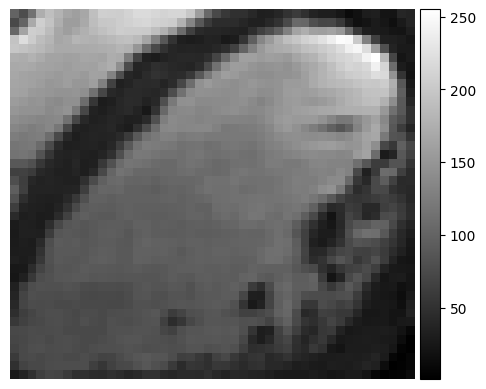

'\nGreat work! ndi.find_objects() becomes extremely useful when dealing with 3-dimensional objects that are harder to view at a glance.\n'

In [91]:
# exercise 03

"""
Extract objects

Extracting objects from the original image eliminates unrelated pixels and provides new images that can be analyzed independently.

The key is to crop images so that they only include the object of interest. The range of pixel indices that encompass the object is the bounding box.
(https://en.wikipedia.org/wiki/Minimum_bounding_box)
For this exercise, use ndi.find_objects() to create a new image containing only the left ventricle.
"""

# Instructions

"""
Create the labels array from mask, then create a mask left ventricle pixels. (Use the coordinates 128, 128 to find the left ventricle label value.)
---
Find the bounding box indices for lv_mask. Print the number of objects found and the values for the first box.
---

    Select the portion of im that is within the left ventricle bounding box.
    Plot the cropped image.

"""

# solution

# Create left ventricle mask
labels, nlabels = ndi.label(mask)
lv_val = labels[128, 128]
lv_mask = np.where(labels == lv_val, 1, 0)

# Find bounding box of left ventricle
bboxes = ndi.find_objects(lv_mask)
print('Number of objects:', len(bboxes))
print('Indices for first box:', bboxes[0])

# Crop to the left ventricle (index 0)
im_lv = im[bboxes[0]]

# Plot the cropped image
plt.imshow(im_lv, cmap='gray')
format_and_render_plot()

#----------------------------------#

# Conclusion

"""
Great work! ndi.find_objects() becomes extremely useful when dealing with 3-dimensional objects that are harder to view at a glance.
"""

![labeled_volume](/home/nero/Documents/Estudos/DataCamp/Python/courses/biomedical-image-analysis-in-python/Ch3_L4_cardiac-vol-exercise.gif)

In [92]:
vol = read_dicom_from_zip_folder(path_data + 'sunnybrook-cardiac-mr.zip', 'SCD2001_006/')[:-1]

In [93]:
# exercise 04

"""
Measure variance

SciPy measurement functions allow you to tailor measurements to specific sets of pixels:

    Specifying labels restricts the mask to non-zero pixels.
    Specifying index value(s) returns a measure for each label value.

For this exercise, calculate the intensity variance of vol with respect to different pixel sets. We have provided the 3D segmented image as labels: label 1 is the left ventricle and label 2 is a circular sample of tissue.

Labeled Volume

After printing the variances, select the true statement from the answers below.
"""

# Instructions

"""
Using vol and labels arrays, measure the variance of pixel intensities in the specified sets of pixels. Print them to the screen.
---
Possible answers:
    
    "Left ventricle" variance is less than "Other tissue" because it uses a smaller set of pixels.
    
    "All pixels" has the lowest variance because it has many pixels with 0 values. {Answer}
    
    "Labeled pixels" high variance because it has the highest mean intensity.
"""

# solution

# Variance for all pixels
var_all = ndi.variance(vol, labels=None, index=None)
print('All pixels:', var_all)

# Variance for labeled pixels
var_labels = ndi.variance(vol, labels, index=None)
print('Labeled pixels:', var_labels)

# Variance for each object
var_objects = ndi.variance(vol, labels, index=[1,2])
print('Left ventricle:', var_objects[0])
print('Other tissue:', var_objects[1])

#----------------------------------#

# Conclusion

"""
Great thinking. Often, global measurements are only useful for understanding the range and distribution of the data.
"""

All pixels: 1022.804685282221
Labeled pixels: 2376.1863828482283
Left ventricle: 3264.5828411664756
Other tissue: 32.869375000000005


'\nGreat thinking. Often, global measurements are only useful for understanding the range and distribution of the data.\n'

In [94]:
im_filt = ndi.median_filter(vol, size=3)
mask_start = np.where(im_filt > 60, 1, 0)
mask = ndi.binary_closing(mask_start)

# Label the objects in "mask"
labels, nlabels = ndi.label(mask)

In [95]:
def format_and_render_plot():
    '''Custom function to simplify common formatting operations for exercises. 
    Operations include: 
    1. Calling `plt.legend()`
    2. Calling `plt.show()` to render plot.'''
    plt.legend()
    plt.xlabel('Intensity Value')
    plt.ylabel('Proportion of Image')
    plt.ylim([0, 0.03])
    plt.show()

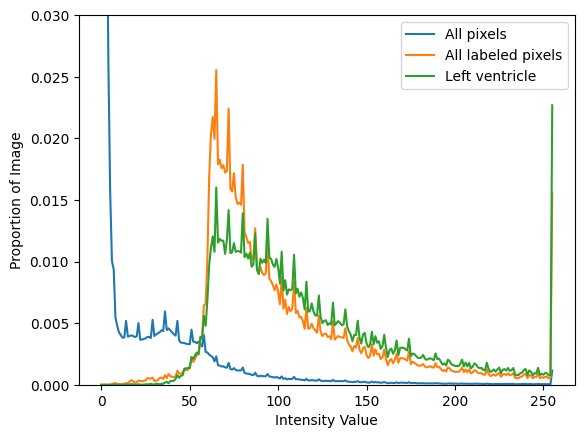

'\nWell done! Notice how the left ventricle segmentation is more normally distributed than the other sets of pixels.\n'

In [96]:
# exercise 05

"""
Separate histograms

A poor tissue segmentation includes multiple tissue types, leading to a wide distribution of intensity values and more variance.

On the other hand, a perfectly segmented left ventricle would contain only blood-related pixels, so the histogram of the segmented values should be roughly bell-shaped.

For this exercise, compare the intensity distributions within vol for the listed sets of pixels. Use ndi.histogram, which also accepts labels and index arguments.
"""

# Instructions

"""
Use the labels and index arguments to extract a histogram for each of the following set of pixels in vol:

    All pixels
    All labeled pixels
    Left ventricle pixels (i.e., label 1)
---

    Plot each histogram using plt.plot(). For each one, rescale by the total number of pixels to allow comparisons between them.

"""

# solution

# Create histograms for selected pixels
hist1 = ndi.histogram(vol, min=0, max=255, bins=256)
hist2 = ndi.histogram(vol, 0, 255, 256, labels=labels)
hist3 = ndi.histogram(vol, 0, 255, 256, labels=labels, index=1)

# Plot the histogram density
plt.plot(hist1 / hist1.sum(), label='All pixels')
plt.plot(hist2 / hist2.sum(), label='All labeled pixels')
plt.plot(hist3 / hist3.sum(), label='Left ventricle')
format_and_render_plot()

#----------------------------------#

# Conclusion

"""
Well done! Notice how the left ventricle segmentation is more normally distributed than the other sets of pixels.
"""

In [97]:
# exercise 06

"""
Calculate volume

Quantifying tissue morphology, or shape is one primary objective of biomedical imaging. The size, shape, and uniformity of a tissue can reveal essential health insights.

For this exercise, measure the volume of the left ventricle in one 3D image (vol).

First, count the number of voxels in the left ventricle (label value of 1). Then, multiply it by the size of each voxel in mm
. (Check vol.meta for the sampling rate.)
"""

# Instructions

"""
Possible answers:
    
    6,459 mm³
    
    117,329 mm³
    
    120,731 mm³ {answer}
    
    18,692 mm³
"""

# solution



#----------------------------------#

# Conclusion

"""

"""

'\n\n'

In [98]:
# exercise 07

"""
Calculate distance

A distance transformation calculates the distance from each pixel to a given point, usually the nearest background pixel. This allows you to determine which points in the object are more interior and which are closer to edges.

For this exercise, use the Euclidian distance transform on the left ventricle object in labels.
(https://en.wikipedia.org/wiki/Euclidean_distance)
"""

# Instructions

"""

    Create a mask of left ventricle pixels (Value of 1 in labels).
    Calculate the distance to background for each pixel using ndi.distance_transform_edt(). Supply pixel dimensions to the sampling argument.
    Print out the maximum distance and its coordinates using ndi.maximum and ndi.maximum_position.
    Overlay a slice of the distance map on the original image. This has been done for you.

"""

# solution

# Calculate left ventricle distances
lv = np.where(labels == 1, 1, 0)
dists = ndi.distance_transform_edt(lv, sampling=vol.meta['sampling'])

# Report on distances
print('Max distance (mm):', ndi.maximum(dists))
print('Max location:', ndi.maximum_position(dists))

# Plot overlay of distances
overlay = np.where(dists[5] > 0, dists[5], np.nan) 
plt.imshow(overlay, cmap='hot')
format_and_render_plot()

#----------------------------------#

# Conclusion

"""
Nicely done. You can make inferences about the shapes of objects by looking at the distribution of distances. For example, a circle will have a uniform distribution of distances along both dimensions.
"""

'\n\n'

Label 1 center: (9.898669198278656, 108.36103425634845, 121.30754964214452)
Label 2 center: (9.73054933087604, 98.21110389746381, 224.09713292424973)


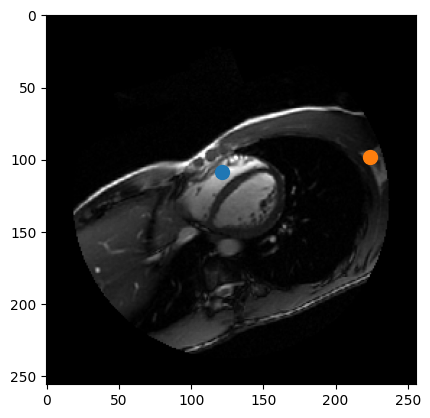

'\nSome shapes, such as those with holes, may have a center of mass that is outside of them.\n'

In [105]:
# exercise 08

"""
Pinpoint center of mass

The distance transformation reveals the most embedded portions of an object. On the other hand, ndi.center_of_mass() returns the coordinates for the center of an object.

The "mass" corresponds to intensity values, with higher values pulling the center closer to it.

For this exercise, calculate the center of mass for the two labeled areas. Then, plot them on top of the image.
"""

# Instructions

"""

    Using vol and labels, calculate the center of mass for the two labeled objects. Print the coordinates.
    Use plt.scatter() to add the center of mass markers to the plot. Note that scatterplots draw from the bottom-left corner. Image columns correspond to x values and rows to y values.

"""

# solution

# Extract centers of mass for objects 1 and 2
coms = ndi.center_of_mass(vol, labels, index=[1,2])
print('Label 1 center:', coms[0])
print('Label 2 center:', coms[1])

# Add marks to plot
plt.imshow(vol[11], cmap='grey')
for c0, c1, c2 in coms:
    plt.scatter(c2, c1, s=100, marker='o')
plt.show()

#----------------------------------#

# Conclusion

"""
Some shapes, such as those with holes, may have a center of mass that is outside of them.
"""

![ejectio_fraction](/home/nero/Documents/Estudos/DataCamp/Python/courses/biomedical-image-analysis-in-python/Ch3_L4_cardiac-ts-exercise.gif)

In [100]:
# exercise 09

"""
Summarize the time series

The ejection fraction is the proportion of blood squeezed out of the left ventricle each heartbeat. To calculate it, radiologists have to identify the maximum volume (systolic volume) and the minimum volume (diastolic volume) of the ventricle.
(https://en.wikipedia.org/wiki/Ejection_fraction)
Slice 4 of Cardiac Timeseries

For this exercise, create a time series of volume calculations. There are 20 time points in both vol_ts and labels. The data is ordered by (time, plane, row, col).
"""

# Instructions

"""

    Initialize an empty array with 20 elements using np.zeros().
    Calculate the volume of each image voxel. (Consult the meta dictionary for sampling rates.)
    For each time point, count the pixels in labels, and update the time series array.
    Plot the time series using plt.plot().

"""

# solution

# Create an empty time series
ts = np.zeros(20)

# Calculate volume at each voxel
d0, d1, d2, d3 = vol_ts.meta['sampling']
dvoxel = d1 * d2 * d3

# Loop over the labeled arrays
for t in range(20):
    nvoxels = ndi.sum(1, labels[t], index=1)
    ts[t] = nvoxels * dvoxel

# Plot the data
plt.plot(ts)
format_and_render_plot()

#----------------------------------#

# Conclusion

"""
Great work! You can see the pumping action of the left ventricle clearly from the time series plot - a sudden decrease followed by a refilling of the chamber.
"""

'\n\n'

![ejection_frac](/home/nero/Documents/Estudos/DataCamp/Python/courses/biomedical-image-analysis-in-python/Ch3_L1_EjFracPath.png)

In [ ]:
# exercise 10

"""
Measure ejection fraction

The ejection fraction is defined as:
(Vmax - Vmin) / Vmax

…where V is left ventricle volume for one 3D timepoint.

To close our investigation, plot slices from the maximum and minimum volumes by analyzing the volume time series (ts). Then, calculate the ejection fraction.

After calculating the ejection fraction, review the chart below. Should this patient be concerned?


"""

# Instructions

"""

    Get the index of the minimum and maximum volume images using np.argmin() and np.argmax().
    Plot the extreme volumes together. Display the images along the fifth plane, e.g. (vol_ts[t, 4]).
---

    Calculate the ejection volume and fraction using the min() and max() methods of ts. Print these values.
---
Possible answers:
    
    Yes, the ejection fraction is higher than normal.
    
    No, the ejection fraction is normal.
    
    Yes, the ejection fraction is lower than normal. {Answer}
"""

# solution

# Get index of max and min volumes
tmax = np.argmax(ts)
tmin = np.argmin(ts)

# Plot the largest and smallest volumes
fig, axes = plt.subplots(2,1)
axes[0].imshow(vol_ts[tmax, 4], vmax=160)
axes[1].imshow(vol_ts[tmin, 4], vmax=160)
format_and_render_plots()

#----------------------------------#

# Calculate ejection fraction
ej_vol = ts.max() - ts.min()
ej_frac = ej_vol / ts.max()
print('Est. ejection volume (mm^3):', ej_vol)
print('Est. ejection fraction:', ej_frac)

#----------------------------------#

# Conclusion

"""
Fantastic! This patient has heart failure with infarction - a serious condition. This case study illustrates a typical image analysis workflow: a single, useful metric is the result of a lot of sophisticated preprocessing, segmentation and measurement techniques.
"""